In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers as L
from tensorflow.keras import callbacks, utils

import spacy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

nlp = spacy.load('en_core_web_lg')

# Loading the Data

In [2]:
dataset = fetch_20newsgroups(subset='all')

X = pd.Series(dataset['data'])
y = pd.Series(dataset['target'])
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=19
)
y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)

**Constants**

In [3]:
vocab_size = 20_000
vocab_pos = 20
vocab_tag = 60
vocab_ner = 20
embed_dim_tok = 128
embed_dim_pos = 64
seq_length = 1024
MAX_EPOCHS = 100

# Tokenization

In [4]:
lemma_pos_tag_train = [[(token.lemma_, token.pos_, token.tag_) for token in nlp(text)] for text in tqdm(X_train)]
lemma_pos_tag_valid = [[(token.lemma_, token.pos_, token.tag_) for token in nlp(text)] for text in tqdm(X_valid)]

ner_train = [["" for _ in range(seq_length)] for text in X_train]
ner_valid = [["" for _ in range(seq_length)] for text in X_valid]

for e, text in tqdm(enumerate(X_train), total=len(X_train)):
    doc = nlp(text)
    for ent in doc.ents:
        ner_train[e][ent.start: ent.end] = [ent.label_] * (ent.end - ent.start)
        
for e, text in tqdm(enumerate(X_valid), total=len(X_valid)):
    doc = nlp(text)
    for ent in doc.ents:
        ner_valid[e][ent.start: ent.end] = [ent.label_] * (ent.end - ent.start)        

  0%|          | 0/16961 [00:00<?, ?it/s]

  0%|          | 0/1885 [00:00<?, ?it/s]

  0%|          | 0/16961 [00:00<?, ?it/s]

  0%|          | 0/1885 [00:00<?, ?it/s]

In [5]:
lem_train = [[token[0] for token in doc] for doc in lemma_pos_tag_train]
lem_valid = [[token[0] for token in doc] for doc in lemma_pos_tag_valid]

pos_train = [[token[1] for token in doc] for doc in lemma_pos_tag_train]
pos_valid = [[token[1] for token in doc] for doc in lemma_pos_tag_valid]

tag_train = [[token[2] for token in doc] for doc in lemma_pos_tag_train]
tag_valid = [[token[2] for token in doc] for doc in lemma_pos_tag_valid]

In [6]:
tokenizer_lem = Tokenizer(num_words=vocab_size, oov_token='<unw>')
tokenizer_lem.fit_on_texts(lem_train)

lem_train = tokenizer_lem.texts_to_sequences(lem_train)
lem_train = sequence.pad_sequences(lem_train, maxlen=seq_length, padding='post')
lem_valid = tokenizer_lem.texts_to_sequences(lem_valid)
lem_valid = sequence.pad_sequences(lem_valid, maxlen=seq_length, padding='post')

tokenizer_pos = Tokenizer(num_words=vocab_pos, oov_token='<unw>')
tokenizer_pos.fit_on_texts(pos_train)

pos_train = tokenizer_pos.texts_to_sequences(pos_train)
pos_train = sequence.pad_sequences(pos_train, maxlen=seq_length, padding='post')
pos_valid = tokenizer_pos.texts_to_sequences(pos_valid)
pos_valid = sequence.pad_sequences(pos_valid, maxlen=seq_length, padding='post')

tokenizer_tag = Tokenizer(num_words=vocab_tag, oov_token='<unw>')
tokenizer_tag.fit_on_texts(tag_train)

tag_train = tokenizer_tag.texts_to_sequences(tag_train)
tag_train = sequence.pad_sequences(tag_train, maxlen=seq_length, padding='post')
tag_valid = tokenizer_tag.texts_to_sequences(tag_valid)
tag_valid = sequence.pad_sequences(tag_valid, maxlen=seq_length, padding='post')

tokenizer_ner = Tokenizer(num_words=vocab_ner, oov_token='<unw>')
tokenizer_ner.fit_on_texts(ner_train)

ner_train = tokenizer_ner.texts_to_sequences(ner_train)
ner_train = sequence.pad_sequences(ner_train, maxlen=seq_length, padding='post')
ner_valid = tokenizer_ner.texts_to_sequences(ner_valid)
ner_valid = sequence.pad_sequences(ner_valid, maxlen=seq_length, padding='post')


lem_train.shape, pos_train.shape, tag_train.shape, ner_train.shape

((16961, 1024), (16961, 1024), (16961, 1024), (16961, 1024))

# Modelling
**Building the Model**


2022-10-10 07:48:07.238163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 07:48:07.239382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 07:48:07.240092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 07:48:07.240981: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1024)]       0                                            
______________________________________________________________________________________________

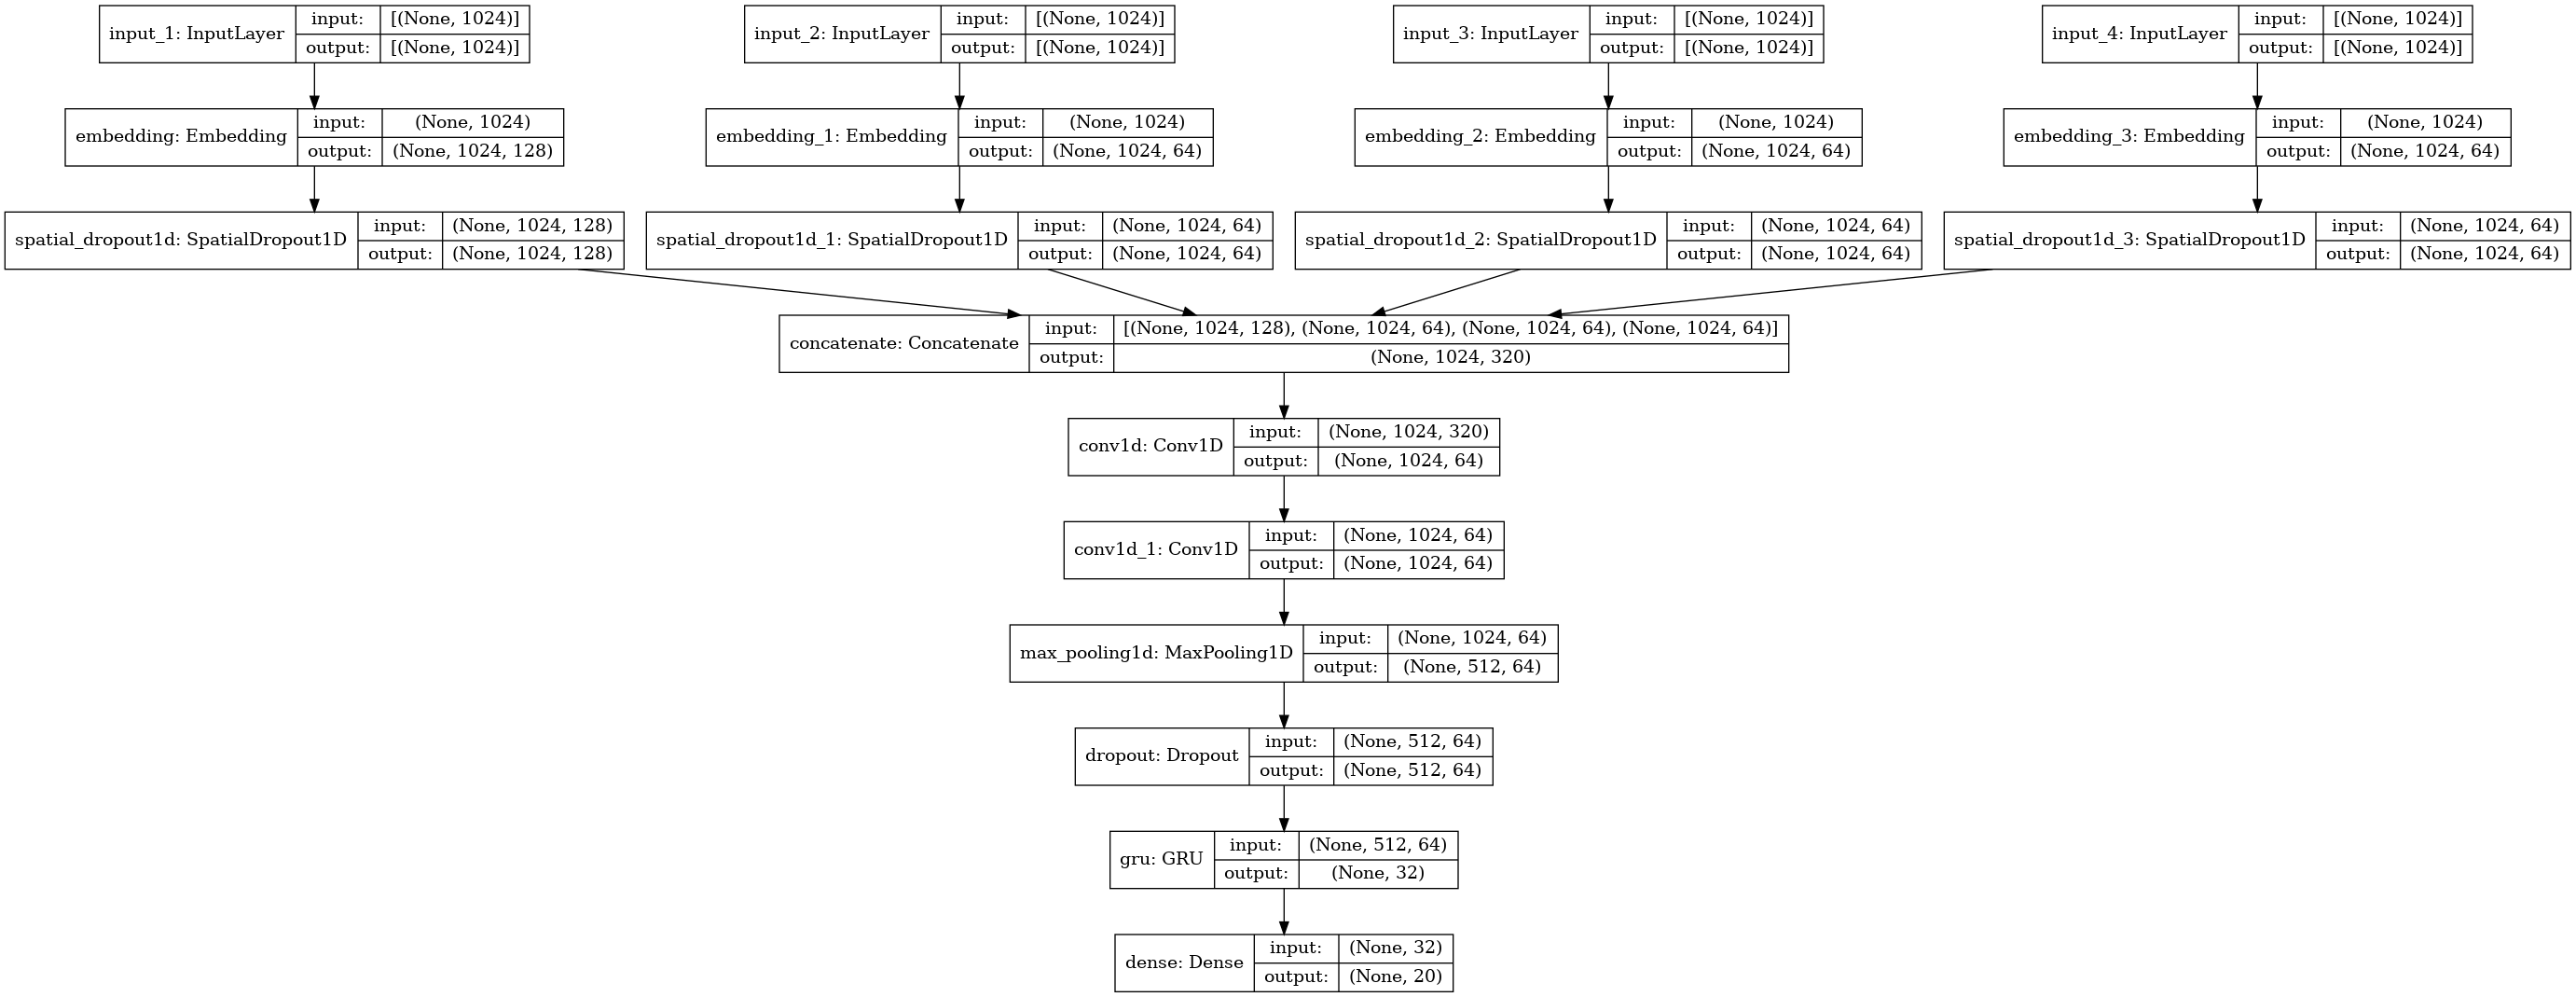

In [7]:
input_tok = L.Input(shape=(seq_length))
input_pos = L.Input(shape=(seq_length))
input_tag = L.Input(shape=(seq_length))
input_ner = L.Input(shape=(seq_length))

emb_tok = L.Embedding(vocab_size, embed_dim_tok, input_length=seq_length)(input_tok)
emb_pos = L.Embedding(vocab_pos, embed_dim_pos, input_length=seq_length)(input_pos)
emb_tag = L.Embedding(vocab_tag, embed_dim_pos, input_length=seq_length)(input_tag)
emb_ner = L.Embedding(vocab_ner, embed_dim_pos, input_length=seq_length)(input_ner)

emb_tok = L.SpatialDropout1D(0.3)(emb_tok)
emb_pos = L.SpatialDropout1D(0.3)(emb_pos)
emb_tag = L.SpatialDropout1D(0.3)(emb_tag)
emb_ner = L.SpatialDropout1D(0.3)(emb_ner)

emb = L.Concatenate()([emb_tok, emb_pos, emb_tag, emb_ner])
x = L.Conv1D(64, 4, padding='same', activation='relu')(emb)
x = L.Conv1D(64, 4, padding='same', activation='relu')(x)
x = L.MaxPool1D(2)(x)
x = L.Dropout(0.3)(x)
x = L.GRU(32)(x)

outputs = L.Dense(20, activation='softmax')(x)

model = models.Model(inputs=[input_tok, input_pos, input_tag, input_ner], outputs=outputs)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
es = callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True
)
rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
utils.plot_model(model, show_shapes=True)

In [8]:
history = model.fit(
    [lem_train, pos_train, tag_train, ner_train], y_train, 
    validation_data=([lem_valid, pos_valid, tag_valid, ner_valid], y_valid),
    callbacks=[es, rlp], epochs=MAX_EPOCHS
)
model.save('stacked_embedding-1dCNN-GRU.h5')

2022-10-10 07:48:17.201659: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-10 07:48:20.349590: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


531/531 [==============================] - 29s 36ms/step - loss: 2.9748 - accuracy: 0.0574 - val_loss: 2.9623 - val_accuracy: 0.0631
Epoch 2/100
531/531 [==============================] - 19s 36ms/step - loss: 2.9475 - accuracy: 0.0673 - val_loss: 2.9464 - val_accuracy: 0.0674
Epoch 3/100
531/531 [==============================] - 19s 36ms/step - loss: 2.9191 - accuracy: 0.0764 - val_loss: 2.9319 - val_accuracy: 0.0753
Epoch 4/100
531/531 [==============================] - 19s 36ms/step - loss: 2.8898 - accuracy: 0.0847 - val_loss: 2.9265 - val_accuracy: 0.0790
Epoch 5/100
531/531 [==============================] - 19s 36ms/step - loss: 2.8691 - accuracy: 0.0940 - val_loss: 2.9194 - val_accuracy: 0.0775
Epoch 6/100
531/531 [==============================] - 19s 36ms/step - loss: 2.7924 - accuracy: 0.1104 - val_loss: 2.6628 - val_accuracy: 0.1385
Epoch 7/100
531/531 [==============================] - 19s 36ms/step - loss: 2.5640 - accuracy: 0.1664 - val_loss: 2.4708 - val_accuracy: 0.18